<a href="https://colab.research.google.com/github/nuentsa/cloud-data-tools/blob/main/runtastic_data/extract_and_load_adidas_running_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# @title Define Global attributes to be used throughout the notebook
from google.colab import userdata
import pandas as pd
# Global attributes
# We will retrieve these specific top-level fields from each sport session file
top_level_fields = [
    "version", "duration", "pause", "calories", "dehydration_volume",
    "start_time_timezone_offset", "end_time_timezone_offset", "start_time",
    "end_time", "created_at", "updated_at", "id", "sport_type_id"
]
# Each sport session has a list of features. We will load only the following ones
features_to_load = ["weather", "map", "track_metrics", "initial_values"]
supported_feature_attributes = ["temperature", "wind_speed", "wind_direction",
                                "humidity", "start_latitude", "start_longitude",
                                "distance", "average_speed", "average_pace",
                                "max_speed", "elevation_gain", "elevation_loss", "distance", "duration"]
# We will save and unzip  the  runtastic file here.
work_dir = "/home/runtastic/"

# Extract the connection string from the notebook secrets
conn_string = userdata.get('postgres_conn_string')

# This File ID is the identifier of your zip file stored in Google Drive
# Oonce you store the zip file in Google drive, retrieve its identifier to store it as secrets in Google Colab
# It should look like this laggVyWshwcyP6kEI-y_W3P8D26sz
runtastic_file_id = userdata.get('runtastic_file_id') # TODO add this file id in a secret


sport_types = [
  [1, 'Running'],
  [62, 'Speed Skiing'],
  [2, 'Nordic Walking'],
  [63, 'PushUps'],
  [3, 'Cycling'],
  [64, 'SitUps'],
  [4, 'Mountain Biking'],
  [65, 'PullUps'],
  [5, 'Other'],
  [66, 'Squats'],
  [6, 'Inline Skating'],
  [7, 'Hiking'],
  [68, 'Baseball'],
  [8, 'Cross-country skiing'],
  [69, 'Crossfit'],
  [9, 'Skiing'],
  [70, 'Dancing'],
  [10, 'Snowboarding'],
  [71, 'Ice Hockey'],
  [11, 'Motorbike'],
  [72, 'Skateboarding'],
  [13, 'Snowshoeing'],
  [73, 'Zumba'],
  [14, 'Treadmill'],
  [74, 'Gymnastics'],
  [15, 'Ergometer'],
  [75, 'Rugby'],
  [16, 'Elliptical'],
  [76, 'Standup Paddling'],
  [17, 'Rowing'],
  [77, 'Sixpack'],
  [18, 'Swimming'],
  [78, 'Butt Training'],
  [19, 'Walking'],
  [80, 'Leg Training'],
  [20, 'Riding'],
  [81, 'Results Workout'],
  [21, 'Golfing'],
  [82, 'Trail Running'],
  [22, 'Race Cycling'],
  [84, 'Plogging'],
  [23, 'Tennis'],
  [85, 'Wheelchair'],
  [24, 'Badminton'],
  [86, 'E Biking'],
  [25, 'Squash'],
  [87, 'Scootering'],
  [26, 'Yoga'],
  [88, 'Rowing Machine'],
  [27, 'Aerobics'],
  [89, 'Stair Climbing'],
  [28, 'Martial Arts'],
  [90, 'Jumping Rope'],
  [29, 'Sailing'],
  [91, 'Trampoline'],
  [30, 'Windsurfing'],
  [92, 'Bodyweight Training'],
  [31, 'Pilates'],
  [93, 'Tabata'],
  [32, 'Rock Climbing'],
  [94, 'Callisthenics'],
  [33, 'Frisbee'],
  [95, 'Suspension Training'],
  [34, 'Strength Training'],
  [96, 'Powerlifting'],
  [35, 'Volleyball'],
  [97, 'Olympic Weightlifting'],
  [36, 'Handbike'],
  [98, 'Stretching'],
  [37, 'Cross Skating'],
  [99, 'Mediation'],
  [38, 'Soccer'],
  [100, 'Bouldering'],
  [42, 'Surfing'],
  [101, 'Via Ferrata'],
  [43, 'Kitesurfing'],
  [102, 'Pade'],
  [44, 'Kayaking'],
  [103, 'Pole Dancing'],
  [45, 'Basketball'],
  [104, 'Boxing'],
  [46, 'Spinning'],
  [105, 'Cricket']
]
# Create a dataframe with the sport types
sport_types_df =  pd.DataFrame(sport_types, columns=['id', 'activity'])

In [4]:
# @title Authenticate to  Google Drive and download the runtastic zip file.
# TODO Use a Google Service Account instead

from pickle import TRUE
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.

downloaded_file = drive.CreateFile({'id': runtastic_file_id})

os.makedirs(work_dir, exist_ok=TRUE)
file_path = os.path.join(work_dir, "runtastic_data_export.zip")
downloaded_file.GetContentFile(file_path)


In [5]:
# @title Unzip the data
# Extract all files from the downloaded archive
import os
import zipfile

#   Recursively displays the folders beneath a specific folder in hierarchical way.
def display_folders(folder_path, indent=0):
  # Get all subfolders and files in the current folder
  subfolders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
  files = [f for f in os.listdir(folder_path) if not os.path.isdir(os.path.join(folder_path, f))]

  # Print the current folder name with indentation
  print(" " * indent + folder_path)
  # Recursively display subfolders
  for subfolder in subfolders:
    display_folders(os.path.join(folder_path, subfolder), indent + 2)

# Open the zip file and extract it
zipobject = zipfile.ZipFile(file_path)
# Unzip all files in a specific directory
zipobject.extractall(work_dir)

# Display the contents of the extracted zip
display_folders(work_dir)

# List all sport sessions
session_files = []
for filename in os.listdir(os.path.join(work_dir, "Sport-sessions")):
  if filename.endswith(".json"):
    session_files.append(os.path.join(work_dir, "Sport-sessions", filename))

# List all gps-data files
gps_data_files = []
for filename in os.listdir(os.path.join(work_dir, "Sport-sessions", "GPS-data")):
  if filename.endswith(".json"):
    gps_data_files.append(os.path.join(work_dir, "Sport-sessions", "GPS-data", filename))


/home/runtastic/
  /home/runtastic/Purchases
    /home/runtastic/Purchases/Subscriptions
    /home/runtastic/Purchases/Subscription-History
  /home/runtastic/Privacy-settings
    /home/runtastic/Privacy-settings/Marketing-consent
  /home/runtastic/Sport-sessions
    /home/runtastic/Sport-sessions/GPS-data
    /home/runtastic/Sport-sessions/Elevation-data
  /home/runtastic/Goals
  /home/runtastic/Challenges
    /home/runtastic/Challenges/Competition_challenge
    /home/runtastic/Challenges/Status
    /home/runtastic/Challenges/Collaboration_challenge
  /home/runtastic/User-Events
  /home/runtastic/Social-connections
    /home/runtastic/Social-connections/Followers
    /home/runtastic/Social-connections/Pending-follow-requests
    /home/runtastic/Social-connections/Following
  /home/runtastic/User-Connections
    /home/runtastic/User-Connections/Adidas
  /home/runtastic/User
    /home/runtastic/User/Avatars
  /home/runtastic/Comments


In [6]:
# @title Load all Sport Sessions
import pandas as pd
import json
import datetime

def process_features(features, id):
  """
  Function to extract and flatten features data, returning the features as a dictionary
  We will use this function to extract and flatten data in the features field
  Each feature has specific metrics and data points : weather, location,
  A list of fastest segments is provided separately as a list of dictionaries.

  Args:
    features: list of features
    id: id of the current session file
  Return:
    feature_values: dictionary of values of interest extracted from each relevant feature
    fastest_segments: list of segments enriched by the sport session id
  """
  feature_values = {}
  segments = []
  for feature in features:
    if feature["type"] == "fastest_segments":
      fastest_segments = feature["attributes"]["segments"]
      segments = extract_fastest_segments(id, fastest_segments)
      continue
    if feature["type"] not in features_to_load:
      continue
    for key, value in feature["attributes"].items():
      if isinstance(value, dict):
        # We will not support the embedding json object here
        continue
      if key not in supported_feature_attributes:
        # We are not interested in this data dimension for now
        continue
      feature_values[key]=value
  return feature_values, segments

def extract_fastest_segments(id, array_of_segments):
  """
  Retrieve the list of fastest segments beneath the features record
  It has the form


  Args:
    array_of_segments: the json array having the list of segments
    id: id of the sport session
  """
  segments = []
  segment_id = 0
  for segment in array_of_segments:
    segment["sessions_id"] = id
    # Generate a unique id for this segment within the context of this session
    segment["id"] = f"{id}-{segment_id}"
    segments.append(segment)
    segment_id += 1
  return segments

# Initialize empty DataFrame to store the sport sessions and the fastest segments
sessions_df = pd.DataFrame()
fastest_segments_df = pd.DataFrame()
# Read each JSON file, process features, and append data to the dataframe
try:
  for filename in session_files:
    with open(filename, "r") as f:
      data = json.load(f)
      # Extract core data
      loaded_data = {}
      for col in top_level_fields:
        loaded_data[col] = data[col]
      # Process features and get a dictionary of feature values
      feature_values, segments = process_features(data["features"], data["id"])
      loaded_data.update(feature_values)
      current_row_df = pd.DataFrame.from_dict(loaded_data, orient='index')
      sessions_df = pd.concat([sessions_df, current_row_df.T], ignore_index=True)

      current_segments_df = pd.DataFrame.from_dict(segments)
      fastest_segments_df = pd.concat([fastest_segments_df, current_segments_df], ignore_index=True)
except Exception as e:
    print(f"Error processing file '{filename}': {e}")

# @title Handle non provided values
# Some features are not present in all sessions like temperature or humidity,
# which lead to NaN fields
nan_columns = sessions_df.columns[sessions_df.isnull().any()]
if len(nan_columns) > 0:
  print('data dimensions with NaN values: ', end=' ')
  print(' '.join(nan_columns))

# Replace them with a predefined sentinel value
sentinel_value = -99999
sessions_df.fillna(sentinel_value, inplace=True)


time_cols = ['start_time', 'end_time', 'created_at', 'updated_at']

# Convert time columns to UTC
sessions_df[time_cols] = sessions_df[time_cols].apply(
    lambda col: pd.to_datetime(col, unit='ms', utc=True), axis=1
)
fastest_segments_df['started_at'] = pd.to_datetime(fastest_segments_df['started_at'], unit='ms', utc=True)
# Convert all duration to seconds instead of milliseconds
duration_cols = ['duration', 'pause', 'start_time_timezone_offset', 'end_time_timezone_offset' ]
for col in duration_cols:
  sessions_df[col] = sessions_df[col] / 1000
fastest_segments_df['duration'] = fastest_segments_df['duration'] / 1000

sessions_df.head()

data dimensions with NaN values:  temperature wind_speed wind_direction humidity


,version,duration,pause,calories,dehydration_volume,start_time_timezone_offset,end_time_timezone_offset,start_time,end_time,created_at,...,wind_direction,humidity,start_latitude,start_longitude,distance,average_speed,average_pace,max_speed,elevation_gain,elevation_loss
0,5,1980.992,1.008,629,799,7200.0,7200.0,2021-04-26 15:49:00+00:00,2021-04-26 16:22:02+00:00,2021-04-26 16:22:02+00:00,...,220.0,76.0,43.635670,1.412459,5728,2.891481,0.345844,3.3939416666666666,15,14
1,7,3010.246,0.000,1098,1590,7200.0,7200.0,2019-09-06 10:14:07+00:00,2019-09-06 11:04:18+00:00,2019-09-06 11:04:19+00:00,...,310.0,39.0,43.564570,1.388515,8449,2.8067473555317406,0.35628429399928985,4.071834,37,36
2,5,3249.891,1.109,916,823,3600.0,3600.0,2022-01-21 11:12:19+00:00,2022-01-21 12:06:30+00:00,2022-01-21 12:06:28+00:00,...,330.0,70.0,43.635696,1.412442,8060,2.4800831781742834,0.403212,3.0352430555555556,52,52
3,5,2601.923,1.077,747,854,3600.0,3600.0,2020-12-03 10:59:27+00:00,2020-12-03 11:42:50+00:00,2020-12-03 11:42:51+00:00,...,180.0,66.0,43.635918,1.412269,7007,2.6930082096972123,0.371332,4.348967,24,26
4,5,3083.467,0.000,1186,1473,7200.0,7200.0,2020-05-17 06:55:23+00:00,2020-05-17 07:46:47+00:00,2020-05-17 07:46:48+00:00,...,280.0,71.0,43.635740,1.412429,9162,2.9713306482605457,0.33654955249945423,3.4269119444444445,26,26


In [ ]:
sessions_df.columns

Index(['version', 'duration', 'pause', 'calories', 'dehydration_volume',
       'start_time_timezone_offset', 'end_time_timezone_offset', 'start_time',
       'end_time', 'created_at', 'updated_at', 'id', 'sport_type_id',
       'temperature', 'wind_speed', 'wind_direction', 'humidity',
       'start_latitude', 'start_longitude', 'distance', 'average_speed',
       'average_pace', 'max_speed', 'elevation_gain', 'elevation_loss'],
      dtype='object')

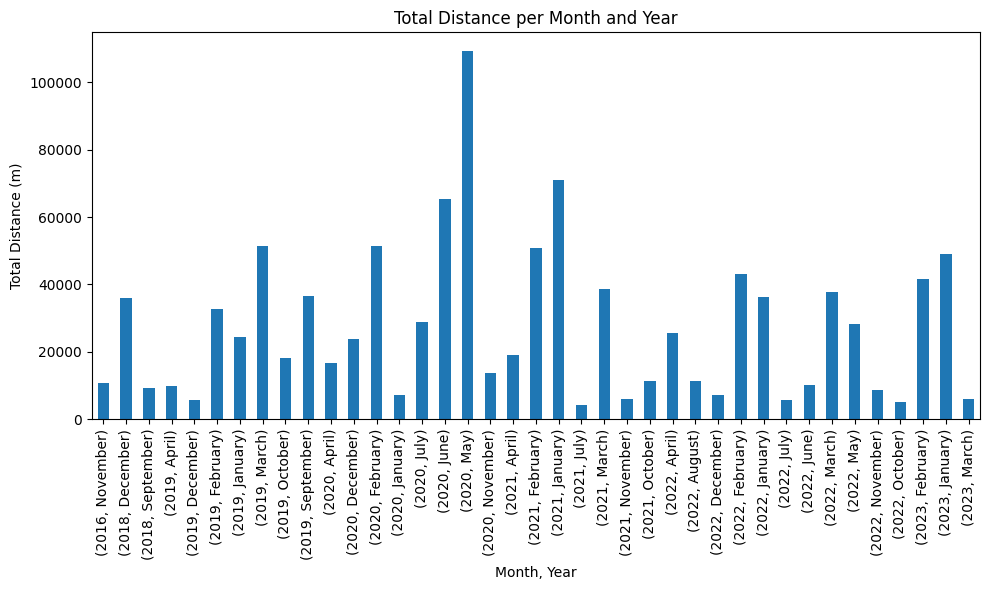

In [24]:
# @title Total Distance per month
import calendar

# Extract month and year from start_time and create new columns 'month' and 'year'
sessions_df['month'] = sessions_df['start_time'].dt.month
sessions_df['year'] = sessions_df['start_time'].dt.year

# Map month number to month name
sessions_df['month'] = sessions_df['month'].apply(lambda x: calendar.month_name[x])

# Group activity per month and year and calculate sum of distance
distance_per_month_year = sessions_df.groupby(['year', 'month'])['distance'].sum()

# Plot sum of distance per month
plt.figure(figsize=(12, 8))  # Adjust figure size
distance_per_month_year.plot(kind='bar', xlabel='Month, Year', ylabel='Total Distance (m)', title='Total Distance per Month and Year', figsize=(10, 6))
plt.xticks(rotation=90)
plt.tight_layout()  # Adjust layout

plt.show()

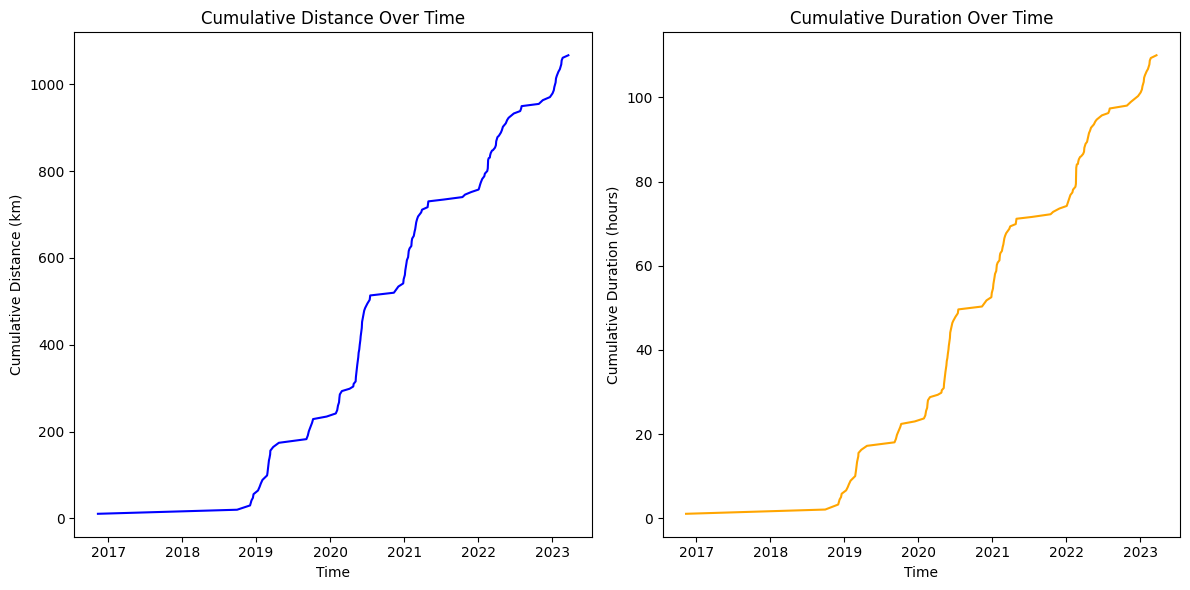

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'start_time' column is in datetime format, if not convert it using pd.to_datetime()
sessions_df['start_time'] = pd.to_datetime(sessions_df['start_time'])

# Sort the dataframe by start_time
sessions_df.sort_values(by='start_time', inplace=True)

# Calculate cumulative sum of distance and duration
sessions_df['cumulative_distance'] = sessions_df['distance'].cumsum() / 1000
sessions_df['cumulative_duration'] = sessions_df['duration'].cumsum() / 3600

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot cumulative distance over time
ax1.plot(sessions_df['start_time'], sessions_df['cumulative_distance'], color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Cumulative Distance (km)')
ax1.set_title('Cumulative Distance Over Time')

# Plot cumulative duration over time
ax2.plot(sessions_df['start_time'], sessions_df['cumulative_duration'], color='orange')
ax2.set_xlabel('Time')
ax2.set_ylabel('Cumulative Duration (hours)')
ax2.set_title('Cumulative Duration Over Time')

plt.tight_layout()  # Adjust layout
plt.show()


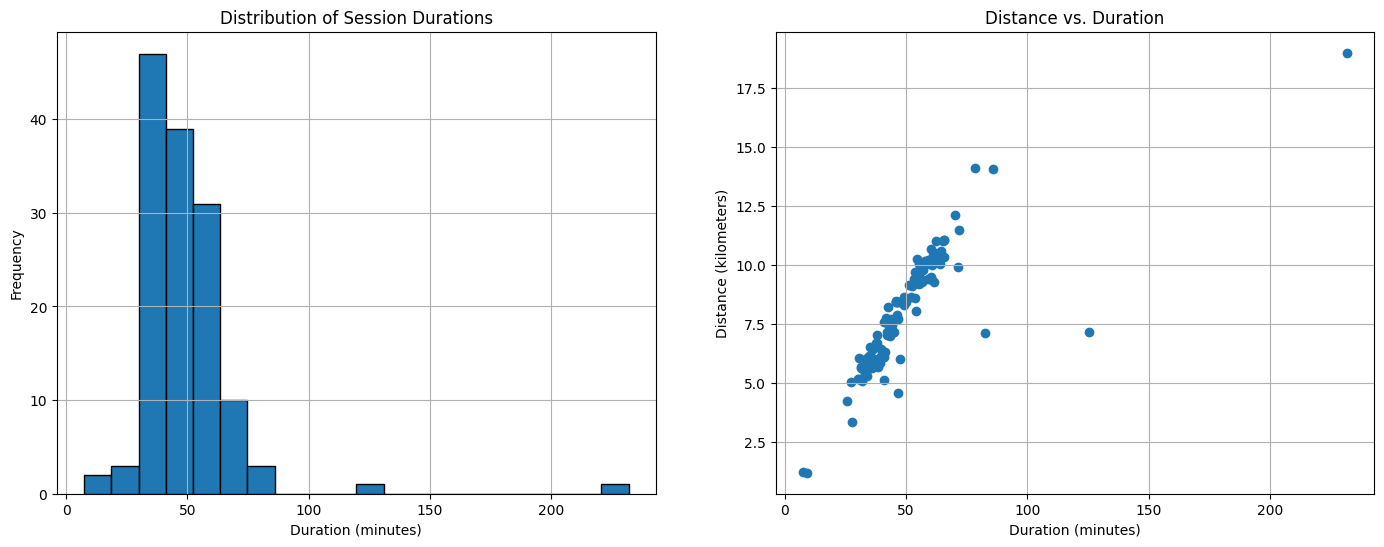

In [11]:
# @title Distance and  Duration of Sport sessions
import matplotlib.pyplot as plt

plt.figure(figsize=(17, 6))

#  Duration distribution
plt.subplot(1, 2, 1)
plt.hist(sessions_df["duration"]/60, bins=20, edgecolor='black')
plt.xlabel("Duration (minutes)")
plt.ylabel("Frequency")
plt.title("Distribution of Session Durations")
plt.grid(True)

# Distance versus duration
plt.subplot(1, 2, 2)
plt.scatter(sessions_df["duration"]/60, sessions_df["distance"]/1000)
plt.xlabel("Duration (minutes)")
plt.ylabel("Distance (kilometers)")
plt.title("Distance vs. Duration")
plt.grid(True)


plt.show()

In [ ]:
# @title Load into  postgres using sqlalchemy
import sqlalchemy as sa
engine = sa.create_engine(conn_string)


sessions_table = "sessions"
fastest_segments_table = "fastest_segments"
sport_types_table = "sport_types"


# Load the sport types
sport_types_df.to_sql(sport_types_table, engine, if_exists='replace')

# Load the sessions data
sessions_df.to_sql(sessions_table, engine, if_exists='replace')

# Load the fastest segments
sessions_df.to_sql(fastest_segments_table, engine, if_exists='replace')

# TODO Add primary and foreign keys